# Analyze the results given by NAS

## Build the network given by NAS 

In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')


import iterative_naive_nas

from sklearn.model_selection import train_test_split

#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import numpy as np

import custom_training

import utils.losses_utils as losses

import utils.data_utils as data_utils

import utils.viz_utils as viz

import matplotlib.pyplot as plt

import matplotlib.animation as animation


#50_partitions
#optimized_parameters = [8.50071696e-04, 3.55273289e-01, 3.86577994e-01, 9.51559796e-01,
# 1.00000000e+00, 1.60000000e+01, 1.57000000e+03]
#30_paritions
#optimized_parameters = [3.46661820e-04, 4.01120020e-01, 9.09580986e-01, 4.13090818e-01,
# 3.93104672e-01, 8.00000000e+00, 8.20000000e+02]
#25_partitions
optimized_parameters = [6.80863834e-04, 4.68269339e-01, 4.51964628e-01, 1.80029101e-01,
 3.94141219e-01, 2.00000000e+00, 7.20000000e+02]
#21_partitions
#optimized_parameters = [1.0e-14, 1.0e-04, 1.0e+00, 1.0e-04, 0.0e+00, 1.6e+01, 8.2e+02]
#21_partitions_tanh
#optimized_parameters = [6.70771985e-04, 3.71587509e-01, 6.03183109e-01, 8.71381868e-01,
#                        3.22005780e-01, 2.00000000e+00, 1.82000000e+03]

learning_rate = float(optimized_parameters[0])
l1_penalization_eeg = float(optimized_parameters[1])
l1_penalization_bold = float(optimized_parameters[2])
l1_penalization_decoder = float(optimized_parameters[3])
loss_coefficient = float(optimized_parameters[4])
batch_size = int(optimized_parameters[5])
current_shape = int(optimized_parameters[6])
#eeg_hidden_shape = int(optimized_parameters[6])
#bold_hidden_shape = int(optimized_parameters[7])
#decoder_hidden_shape = int(optimized_parameters[8])

bold_shift=3
f_resample=1.8
n_partitions=25
by_partitions=False
partition_length=14
fmri_resolution_factor=3
mutate_bands=True
activation=''
dataset="01"

if(activation):
    eeg_file='../../optimized_nets/eeg/eeg_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    bold_file='../../optimized_nets/bold/bold_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    decoder_file='../../optimized_nets/decoder/decoder_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    
else:
    eeg_file='../../optimized_nets/eeg/eeg_' + str(n_partitions) + '_partitions.json'
    bold_file='../../optimized_nets/bold/bold_' + str(n_partitions) + '_partitions.json'
    decoder_file='../../optimized_nets/decoder/decoder_' + str(n_partitions) + '_partitions.json'

gpus=tf.config.list_physical_devices('GPU')
if(len(gpus)):
    tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

In [2]:
eeg_train, bold_train, mask, scalers = data_utils.load_data(list(range(10)),#n_voxels=n_voxels, 
                                                            bold_shift=bold_shift, 
                                                            n_partitions=n_partitions, 
                                                            by_partitions=by_partitions, 
                                                            partition_length=partition_length, 
                                                            f_resample=f_resample, 
                                                            mutate_bands=False,
                                                            fmri_resolution_factor=fmri_resolution_factor,
                                                            standardize_eeg=False, 
                                                            standardize_fmri=True,
                                                            dataset=dataset)

n_partitions=bold_train.shape[0]//bold_train.shape[2]
n_voxels = bold_train.shape[1]
interval_length = bold_train.shape[2]

eeg_train = eeg_train.reshape(eeg_train.shape+(1,))
bold_train = bold_train.reshape(bold_train.shape+(1,))

print("Finished Loading Data")

(300, 882)
(300, 882)
(300, 882)
(300, 882)
(300, 882)
(300, 882)
(300, 882)
(300, 882)
(300, 882)
(300, 882)
(250, 64, 111, 14)
(250, 882, 14)
Finished Loading Data


In [3]:
n_individuals_train=10
n_individuals_test=4

eeg_val = eeg_train[n_individuals_train*n_partitions:n_individuals_train*n_partitions+n_individuals_test*n_partitions]
eeg_train = eeg_train[:n_individuals_train*n_partitions]
bold_val = bold_train[n_individuals_train*n_partitions:n_individuals_train*n_partitions+n_individuals_test*n_partitions]
bold_train = bold_train[:n_individuals_train*n_partitions]

In [4]:
min_train = np.amin(bold_train)
min_val = np.amin(bold_val)

print(min_train, min_val)

max_value = np.amin([min_train, min_val])

print(max_value)

#bold_train = bold_train - max_value+0.001
#bold_test = bold_test - max_value+0.001

#bold_train = np.log(bold_train)
#bold_test = np.log(bold_test)

-6.156808 -6.044648
-6.156808


In [5]:
eeg_train = eeg_train.astype('float32')
bold_train = bold_train.astype('float32')

eeg_val = eeg_val.astype('float32')
bold_val = bold_val.astype('float32')

eeg_test = None
bold_test = None

In [6]:
X_train_eeg, X_train_bold, tr_y, X_bold_train_target = data_utils.create_eeg_bold_pairs(eeg_train, bold_train, instances_per_individual=n_partitions)
X_val_eeg, X_val_bold, tv_y, X_bold_val_target = data_utils.create_eeg_bold_pairs(eeg_val, bold_val, instances_per_individual=n_partitions)

tr_y = np.array(tr_y, dtype='float32')
tv_y = np.array(tv_y, dtype='float32')

<IPython.core.display.Javascript object>


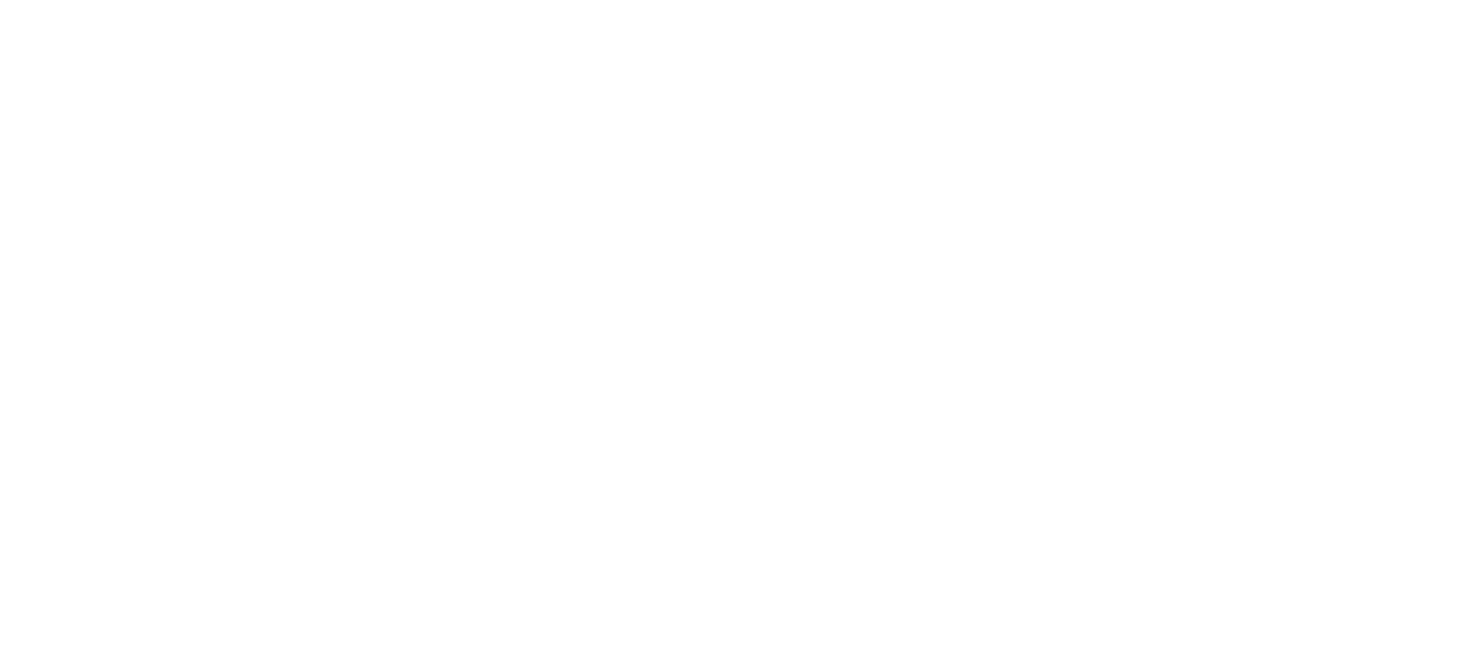

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [60]:
from numpy.linalg import norm

%matplotlib notebook

individual=0
normalize=False

real_mapping = np.copy(bold_train[individual,:, :, 0])
synth_mapping = np.copy(decoder_network(eeg_network(eeg_train)).numpy()[individual,:, :, 0])

if(normalize):
    for voxel in range(len(real_mapping[individual])):
        real_mapping[individual][voxel] = real_mapping[individual][voxel]/norm(real_mapping[individual][voxel])            
        synth_mapping[individual][voxel] = synth_mapping[individual][voxel]/norm(synth_mapping[individual][voxel])

n_frames = real_mapping.shape[1]

fig, axes = plt.subplots(1,2, figsize=(9,4))
ax1, ax2 = axes

ims1 = []
ims2 = []

for frame in range(n_frames):
    im1 = ax1.imshow(np.resize(real_mapping[:,frame], (50, 52)), 
                     cmap='gnuplot2', interpolation='nearest', animated=True)
    im2 = ax2.imshow(np.resize(synth_mapping[:,frame], (50, 52)), 
                     cmap='gnuplot2', interpolation='nearest', animated=True)
    ims1.append([im1])
    ims2.append([im2])

ani1 = animation.ArtistAnimation(fig, ims1, interval=500, blit=True, repeat_delay=1000)
ani2 = animation.ArtistAnimation(fig, ims2, interval=500, blit=True, repeat_delay=1000)

ani1_html= open("ani1.html","w")
ani1_html.write(ani1.to_html5_video())
ani1_html.close()

In [61]:
from utils import fmri_utils, viz_utils

import importlib
importlib.reload(viz_utils)

individual=0
timestep=6

synthesized = decoder_network(eeg_network(eeg_train)).numpy()[individual*n_partitions+timestep]
synthesized = synthesized.reshape((1,)+synthesized.shape[:-1])
bold_instance=bold_train[individual*n_partitions+timestep]
bold_instance=bold_instance.reshape((1,)+bold_instance.shape[:-1])

synth_vmin=np.amin(synthesized+np.abs(np.amin(synthesized))+0.1)
synth_vmax=np.amax(synthesized+np.abs(np.amin(synthesized))+0.1)
real_vmin=np.amin(bold_instance+np.abs(np.amin(bold_instance))+0.1)
real_vmax=np.amax(bold_instance+np.abs(np.amin(bold_instance))+0.1)

synthesized_nifti_images = fmri_utils.get_nifti_from_set(synthesized+np.abs(np.amin(synthesized))+0.1, 
                                                      mask.mask_img_)
real_nifti_images = fmri_utils.get_nifti_from_set(bold_instance+np.abs(np.amin(bold_instance))+0.1, 
                                                                         mask.mask_img_)

viz_utils.plot_view_mask(synthesized_nifti_images[0], 
                        timestep=timestep, 
                        vmin=synth_vmin,
                        vmax=synth_vmax,
                        symmetric_cmap=False,
                        resampling_factor=fmri_resolution_factor,
                        save_file="../../results/tmp/plot_synthesized_"+str(individual//n_partitions)+"_"+str(timestep)+"_"+mode+".html")
viz_utils.plot_view_mask(real_nifti_images[0], 
                        timestep=timestep, 
                        vmin=real_vmin,
                        vmax=real_vmax,
                        symmetric_cmap=False,
                        resampling_factor=fmri_resolution_factor,
                        save_file="../../results/tmp/plot_real_"+str(individual//n_partitions)+"_"+str(timestep)+".html")

In [17]:
23*51


1173

In [18]:
#build model
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

it_nas = iterative_naive_nas.Iterative_Naive_NAS()

tmp_eeg_network = tf.keras.Sequential()
#tmp_eeg_network.add(tf.keras.layers.Conv3D(1, kernel_size=(10,4,1), activation='linear',strides=(2,3,1), input_shape=eeg_train.shape[1:], kernel_regularizer=iterative_naive_nas.l1_reg(l1_penalization_eeg), bias_regularizer=iterative_naive_nas.l1_reg(l1_penalization_eeg),kernel_initializer=tf.keras.initializers.Constant(value=0.5),bias_initializer=tf.keras.initializers.Constant(value=0.5)))
tmp_eeg_network.add(tf.keras.layers.Conv3D(1, kernel_size=(20,10,1), activation='relu',strides=(2,2,1), input_shape=eeg_train.shape[1:], kernel_regularizer=iterative_naive_nas.l1_reg(l1_penalization_eeg), bias_regularizer=iterative_naive_nas.l1_reg(l1_penalization_eeg),kernel_initializer=tf.keras.initializers.Constant(value=0.5),bias_initializer=tf.keras.initializers.Constant(value=0.5)))
tmp_eeg_network.add(tf.keras.layers.Reshape((1173,14, 1)))
tmp_eeg_network.build(input_shape=eeg_train.shape[1:])

tmp_bold_network=tf.keras.Sequential()
tmp_bold_network.add(it_nas.build_layer_Conv2DTranspose(bold_train.shape[1:], (1173,14,1), regularization=l1_penalization_bold)[0])
tmp_bold_network.build(input_shape=bold_train[1:])

tmp_decoder_network=tf.keras.Sequential()
tmp_decoder_network.add(it_nas.build_layer_Conv2D((1173,14,1), bold_train.shape[1:], regularization=l1_penalization_decoder)[0])
tmp_decoder_network.build(input_shape=(None,1173,14,1))

### Train the network

In [ ]:
import importlib
importlib.reload(custom_training)
importlib.reload(losses)

eeg_network, bold_network, decoder_network=(tmp_eeg_network, tmp_bold_network, tmp_decoder_network)
#eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
#                                                                      bold_file=bold_file, 
#                                                                      decoder_file=decoder_file)

#bold_network = tmp_bold_network
#decoder_network = tmp_decoder_network

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])

print(eeg_input_shape, bold_input_shape)

mode="lstm_zeeg_nfmri"
multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, 
                                                        corr_distance=True,
                                                        dist_function=losses.mean_volume_euclidean,
                                                        lstm=False,
                                                        gan=False,
                                                        gan_activation="softmax",
                                                        gan_output_dimension=1)

validation_loss = custom_training.linear_combination_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network,
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            epochs=40, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            batch_size=batch_size, 
                                                            loss_function=losses.get_reconstruction_log_cosine_loss,
                                                            #linear_combination=loss_coefficient,
                                                            linear_combination=1.0,
                                                            clip_value_loss=np.inf,#for lstm better 3.0
                                                            clip_value_gradient=3.0,#for lstm better 1.0
                                                            margin_constrastive=1.0,#for lstm better 0.8
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y,
                                                            eeg_train=eeg_train, 
                                                            bold_train=bold_train, 
                                                            eeg_val=eeg_val, 
                                                            bold_val=bold_val,
                                                            X_bold_train_target=X_bold_train_target,
                                                            X_bold_val_target=X_bold_val_target,
                                                            verbose=False)

model_name = "LComb"

(64, 111, 14, 1) (882, 14, 1)
Encoder Loss:  4119.2056  || Decoder Loss:  -0.09117488 Validation Decoder Loss:  -0.24839547
Encoder Loss:  3328.206  || Decoder Loss:  -0.09118452 Validation Decoder Loss:  -0.24841808
Encoder Loss:  2537.6902  || Decoder Loss:  -0.09119664 Validation Decoder Loss:  -0.24844427
Encoder Loss:  1748.3062  || Decoder Loss:  -0.09121996 Validation Decoder Loss:  -0.24847305
Encoder Loss:  963.73914  || Decoder Loss:  -0.09133946 Validation Decoder Loss:  -0.24763806
Encoder Loss:  285.08957  || Decoder Loss:  -0.09140655 Validation Decoder Loss:  -0.2472854
Encoder Loss:  142.71892  || Decoder Loss:  -0.09140638 Validation Decoder Loss:  -0.24720417
Encoder Loss:  115.04779  || Decoder Loss:  -0.09142886 Validation Decoder Loss:  -0.24715805
Encoder Loss:  86.89679  || Decoder Loss:  -0.09142844 Validation Decoder Loss:  -0.24701399
Encoder Loss:  56.818516  || Decoder Loss:  -0.09145472 Validation Decoder Loss:  -0.246969
Encoder Loss:  26.125525  || Decode

In [9]:
viz.plot_loss_results(eeg_train, bold_train, None, None, eeg_val, bold_val, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

NameError: name 'model_name' is not defined

### Try the same hyperparameters, but in an autoencoder training process without the bold branch

In [56]:
importlib.reload(losses)
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

#0.16 True True
#0.18 False False
#0.16  True False
#0.25  False True
eeg_network, bold_network, decoder_network=(tmp_eeg_network, tmp_bold_network, tmp_decoder_network)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])


auto_encoder_model = custom_training.auto_encoder_network(eeg_input_shape, eeg_network, decoder_network)
mode="ae"
validation_loss = custom_training.autoencoder_training(X_train_eeg, 
                                                    X_train_bold, 
                                                    auto_encoder_model, 
                                                    epochs=40, 
                                                    auto_encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                    loss_function=losses.get_reconstruction_log_cosine_loss,
                                                    batch_size=batch_size, 
                                                    X_val_eeg=eeg_val, 
                                                    X_val_bold=bold_val,
                                                    eeg_train=eeg_train, 
                                                    bold_train=bold_train, 
                                                    eeg_val=eeg_val, 
                                                    bold_val=bold_val,
                                                    X_bold_train_target=X_bold_train_target,
                                                    X_bold_val_target=X_bold_val_target)

model_name = "AE"

Autoencoder Loss:  -0.24711436 || Validation Autoencoder Loss:  -0.3500544
Autoencoder Loss:  -0.24951313 || Validation Autoencoder Loss:  -0.347131
Autoencoder Loss:  -0.25171858 || Validation Autoencoder Loss:  -0.34623566
Autoencoder Loss:  -0.25346687 || Validation Autoencoder Loss:  -0.34491354
Autoencoder Loss:  -0.25471723 || Validation Autoencoder Loss:  -0.34482503
Autoencoder Loss:  -0.25551304 || Validation Autoencoder Loss:  -0.34484935
Autoencoder Loss:  -0.25602475 || Validation Autoencoder Loss:  -0.34509364
Autoencoder Loss:  -0.25637385 || Validation Autoencoder Loss:  -0.3452927
Autoencoder Loss:  -0.25663808 || Validation Autoencoder Loss:  -0.34516633
Autoencoder Loss:  -0.25685307 || Validation Autoencoder Loss:  -0.34503993
Autoencoder Loss:  -0.25703228 || Validation Autoencoder Loss:  -0.34491932
Autoencoder Loss:  -0.25718546 || Validation Autoencoder Loss:  -0.3448133
Autoencoder Loss:  -0.25732055 || Validation Autoencoder Loss:  -0.3447448
Autoencoder Loss: 

KeyboardInterrupt: 

In [ ]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Try the same hyperparameters, but in an adversarial training process

In [23]:
import tensorflow as tf
import tensorflow.keras.backend as K


def loss_minmax_discriminator(real_pred, real_true, gen_pred, log=False):
    #need to separate positives from negatives

    #log(1) = 0
    positives = np.array([[1., 0., 0.]], dtype='float32').repeat(real_pred.shape[0],0)
    #log(1-1) = 0
    negatives = np.array([[0., 1., 0.]], dtype='float32').repeat(real_pred.shape[0],0)
    for instance in range(real_true.shape[0]):
        if(real_true[instance] == 1.0):
            positives[instance] = real_pred[instance][0].numpy()
        else:
            negatives[instance] = real_pred[instance][0].numpy()

    positives = tf.convert_to_tensor(positives)
    negatives = tf.convert_to_tensor(negatives)
    
    if(log):
        loss = (tf.log(positives) + tf.log(1. - negatives) + tf.log(1. - gen_pred)) / 3.
    else:
        

        loss = ((tf.constant(np.array([1., 0., 0.]), dtype="float32") - positives) + \
                (tf.constant(np.array([0., 1., 0.]), dtype="float32") - negatives) + \
                (tf.constant(np.array([0., 0., 1.]), dtype="float32") - gen_pred))
    
    return tf.reduce_mean(loss)


def loss_minmax_generator(gen_pred, log=False):
    
    if(log):
        return tf.reduce_mean(tf.log(gen_pred))
    
    return tf.reduce_mean(tf.abs(tf.constant(np.array([1., 0., 0.]), dtype="float32") - gen_pred))

def grad_decoder_adversarial(discriminator, synthesizer, z, eeg, bold, y_pairs, clip=True, clip_value=2, d_loss=losses.loss_minmax_discriminator, g_loss=losses.loss_minmax_generator):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        
        tape.watch(z)
        tape.watch(synthesizer.variables)

        eeg = tf.convert_to_tensor(eeg)
        bold = tf.convert_to_tensor(bold)
                 
        synthesized = synthesizer(z)

        #pair synthesized with eeg
        real_labels = discriminator([eeg, bold])
        gen_labels = discriminator([eeg, synthesized])
        
        discriminator_loss = d_loss(real_labels, y_pairs, gen_labels)
        synthesizer_loss = g_loss(gen_labels)
        
        if(clip):
            discriminator_loss = tf.clip_by_value(discriminator_loss, -clip_value, clip_value)
            synthesizer_loss = tf.clip_by_value(synthesizer_loss, -clip_value, clip_value)

        return synthesizer_loss, discriminator_loss, tape.gradient(synthesizer_loss, 
                                            synthesizer.trainable_weights)

In [24]:
"""
sensitive_adversarial_training: Adversarial Training

Changing from training the D/G based on the accuracy of G/D given a threshold (0.5)
        
"""
def sensitive_adversarial_training(X_train_eeg, X_train_bold, tr_y, eeg_network, 
    decoder_model, multi_modal_model, epochs=10, 
    discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    generator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    g_loss_function=losses.loss_minmax_generator,
    d_loss_function=losses.loss_minmax_discriminator,
    linear_combination=1.0, 
    clip=True,
    clip_value_gradient=0.5, 
    clip_value_loss=2, 
    batch_size=128,
    X_val_eeg=None, X_val_bold=None, tv_y=None, 
    eeg_train=None, bold_train=None, eeg_val=None, bold_val=None,
    X_bold_train_target=None,
    X_bold_val_target=None,
    session=None, verbose=1):


    validation = False
    if(X_val_eeg is not None and X_val_bold is not None and tv_y is not None):
        validation = True

    global_step = tf.Variable(0)
    
    training_d = True
    training_g = False

    _losses = custom_training.custom_training_loss()
    n_epochs = 0

    while(n_epochs < epochs):
        if(training_d):
            print("Training Discriminator")
        elif(training_g):
            print("Training Generator")
        
        decoder_loss = _losses.get_batch_decoder_loss_avg()
        encoder_loss = _losses.get_batch_encoder_loss_avg()
        
        if(training_d and decoder_loss > encoder_loss and encoder_loss != np.inf):
            print("Finished Discriminator\nChanging to Generator")
            training_d = False
            training_g = True
            _losses = custom_training.custom_training_loss()
        elif(training_g and encoder_loss > decoder_loss):
            print("Finished Generator\nChanging to Discriminator")
            training_d = True
            training_g = False
            n_epochs += 1
            _losses = custom_training.custom_training_loss()
        
        for batch_init in range(0, len(X_train_eeg), batch_size):
            batch_start = batch_init
            if(batch_start + batch_size >= len(X_train_eeg)):
                batch_stop = len(X_train_eeg)
            else:
                batch_stop = batch_start + batch_size
            
            shared_eeg = eeg_network(tf.gather_nd(eeg_train, X_train_eeg[batch_start:batch_stop]))
            
            if(training_g):
                # Optimize the synthesizer mode
                decoder_loss, encoder_loss, decoder_grads = grad_decoder_adversarial(multi_modal_model, decoder_model, 
                                                                        shared_eeg,
                                                                        tf.gather_nd(eeg_train, X_train_eeg[batch_start:batch_stop]), 
                                                                        tf.gather_nd(bold_train, X_train_bold[batch_start:batch_stop]), 
                                                                        tr_y[batch_start:batch_stop],
                                                                        d_loss=d_loss_function,
                                                                        g_loss=g_loss_function,
                                                                        clip=clip,
                                                                        clip_value=clip_value_loss)
                with tf.name_scope("gradient_decoder") as scope:
                    generator_optimizer.apply_gradients(zip(decoder_grads, decoder_model.trainable_variables), name=scope)
                
            elif(training_d):
                #now train the compression by correlation model
                encoder_loss, decoder_loss, encoder_grads = custom_training.grad_multi_encoder_adversarial(multi_modal_model, decoder_model, 
                                                                        shared_eeg,
                                                                        tf.gather_nd(eeg_train, X_train_eeg[batch_start:batch_stop]), 
                                                                        tf.gather_nd(bold_train, X_train_bold[batch_start:batch_stop]), 
                                                                        tr_y[batch_start:batch_stop],
                                                                        d_loss=d_loss_function,
                                                                        g_loss=g_loss_function,
                                                                        clip=clip,
                                                                        clip_value=clip_value_loss)
                
                with tf.name_scope("gradient_encoders") as scope:
                    if(clip):
                        encoder_clipped_grads = ()
                        for grad in encoder_grads:
                            encoder_clipped_grads += (tf.clip_by_value(grad, clip_value_min=-clip_value_gradient, clip_value_max=clip_value_gradient), )
                        encoder_grads=encoder_clipped_grads
                        
                    discriminator_optimizer.apply_gradients(zip(encoder_grads, multi_modal_model.trainable_variables), name=scope)
                
            # Track progress
            _losses.update_batch_decoder_loss_avg(decoder_loss)
            _losses.update_batch_encoder_loss_avg(encoder_loss)

        # end epoch
        decoder_loss = _losses.get_batch_decoder_loss_avg()
        encoder_loss = _losses.get_batch_encoder_loss_avg()

        #get validation analyses
        #get validation analyses
        shared_eeg_train = eeg_network(tf.gather_nd(eeg_train, X_train_eeg))
        shared_eeg_val = eeg_network(tf.gather_nd(eeg_val, X_val_eeg))
        train_reconstruction_loss = losses.get_reconstruction_log_cosine_loss(decoder_model(shared_eeg_train), tf.gather_nd(bold_train, X_train_bold))
        val_reconstruction_loss = losses.get_reconstruction_log_cosine_loss(decoder_model(shared_eeg_val), tf.gather_nd(bold_val, X_val_bold))
        
        if(verbose):
            print("GAN Encoder Loss: ", tf.keras.backend.eval(encoder_loss), 
                " || GAN Decoder Loss: ", tf.keras.backend.eval(decoder_loss),
                " || Train Reconstruction Loss: ", tf.keras.backend.eval(train_reconstruction_loss),
                " || Validation Reconstruction Loss: ", tf.keras.backend.eval(val_reconstruction_loss))
            sys.stdout.flush()

    shared_eeg_val = eeg_network(tf.gather_nd(eeg_val, X_val_eeg))
    return tf.keras.backend.eval(custom_training.loss_decoder(decoder_model(shared_eeg_val), tf.gather_nd(bold_val, X_val_bold)))

In [59]:
import importlib
importlib.reload(custom_training)
importlib.reload(losses)

eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_network, bold_network, decoder_network=(tmp_eeg_network, tmp_bold_network, tmp_decoder_network)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, 
                                                        dcca=False, 
                                                        lstm=True,
                                                        corr_distance=True,
                                                        dist_function=losses.correlation_angle,
                                                        gan=False,
                                                        gan_activation="softmax",
                                                        gan_output_dimension=1)
mode="gan"
validation_loss = custom_training.adversarial_training(X_train_eeg, 
                                       X_train_bold, 
                                       tr_y, 
                                       eeg_network, decoder_network, multi_modal_model, 
                                       epochs=5, 
                                       discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
                                       generator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
                                       batch_size=batch_size, 
                                       g_loss_function=loss_minmax_generator,
                                       d_loss_function=loss_minmax_discriminator,
                                       linear_combination=loss_coefficient, 
                                       clip=True,
                                       clip_value_loss=3.0,
                                       clip_value_gradient=1.5,
                                       X_val_eeg=X_val_eeg, 
                                       X_val_bold=X_val_bold, 
                                       tv_y=tv_y,
                                       eeg_train=eeg_train, 
                                       bold_train=bold_train, 
                                       eeg_val=eeg_val, 
                                       bold_val=bold_val,
                                       X_bold_train_target=X_bold_train_target,
                                       X_bold_val_target=X_bold_val_target)

model_name = "GAN"

GAN Encoder Loss:  -0.59144056  || GAN Decoder Loss:  0.33210075  || GAN Validation Decoder Loss:  -0.41518676  || Train Reconstruction Loss:  -0.24658279  || Validation Reconstruction Loss:  -0.41518676
GAN Encoder Loss:  -0.59185535  || GAN Decoder Loss:  0.3324267  || GAN Validation Decoder Loss:  -0.41518635  || Train Reconstruction Loss:  -0.2465829  || Validation Reconstruction Loss:  -0.41518635
GAN Encoder Loss:  -0.59190255  || GAN Decoder Loss:  0.33271164  || GAN Validation Decoder Loss:  -0.41518617  || Train Reconstruction Loss:  -0.24658303  || Validation Reconstruction Loss:  -0.41518617
GAN Encoder Loss:  -0.5917633  || GAN Decoder Loss:  0.3328786  || GAN Validation Decoder Loss:  -0.41518626  || Train Reconstruction Loss:  -0.24658312  || Validation Reconstruction Loss:  -0.41518626
GAN Encoder Loss:  -0.59155643  || GAN Decoder Loss:  0.3329818  || GAN Validation Decoder Loss:  -0.41518632  || Train Reconstruction Loss:  -0.24658318  || Validation Reconstruction Loss

In [ ]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Try to check if alternate training between LComb and GAN training

In [30]:
#eeg_network, bold_network, decoder_network = get_models_and_shapes()

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False)


validation_loss = custom_training.linear_combination_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network, 
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            epochs=5, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            batch_size=batch_size, 
                                                            linear_combination=loss_coefficient,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y)

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False, corr_distance=True)

validation_loss = custom_training.adversarial_training(X_train_eeg, 
                                                       X_train_bold, 
                                                       tr_y, 
                                                       eeg_network, decoder_network, multi_modal_model, 
                                                       epochs=5, 
                                                       discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       generator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       batch_size=batch_size, 
                                                       linear_combination=loss_coefficient, 
                                                       X_val_eeg=X_val_eeg, 
                                                       X_val_bold=X_val_bold, 
                                                       tv_y=tv_y)

Encoder Loss:  0.118197516  || Decoder Loss:  -0.10892728 Validation Decoder Loss:  -0.34396172
Encoder Loss:  0.17350961  || Decoder Loss:  -0.21215793 Validation Decoder Loss:  -0.417525
Encoder Loss:  0.17483221  || Decoder Loss:  -0.21957809 Validation Decoder Loss:  -0.42274988
Encoder Loss:  0.17368379  || Decoder Loss:  -0.22170837 Validation Decoder Loss:  -0.42290154
Encoder Loss:  0.17259873  || Decoder Loss:  -0.22295734 Validation Decoder Loss:  -0.42123955
GAN Encoder Loss:  1.0127182  || GAN Decoder Loss:  0.14818361  || GAN Validation Decoder Loss:  -0.7285427  || Train Reconstruction Loss:  0.083577104  || Validation Reconstruction Loss:  0.5169993
GAN Encoder Loss:  0.5068348  || GAN Decoder Loss:  0.5557646  || GAN Validation Decoder Loss:  -0.36623427  || Train Reconstruction Loss:  0.12438231  || Validation Reconstruction Loss:  0.30665627
GAN Encoder Loss:  0.24195859  || GAN Decoder Loss:  1.0542921  || GAN Validation Decoder Loss:  -0.2962604  || Train Reconstruc

train set mean:  -0.13035505447935844
train set std:  0.10439693812962365
validation set mean:  -0.2702327285494123
validation set std:  0.007279591704164774
test set mean:  -0.2692250900325321
test set std:  0.013276322805917784


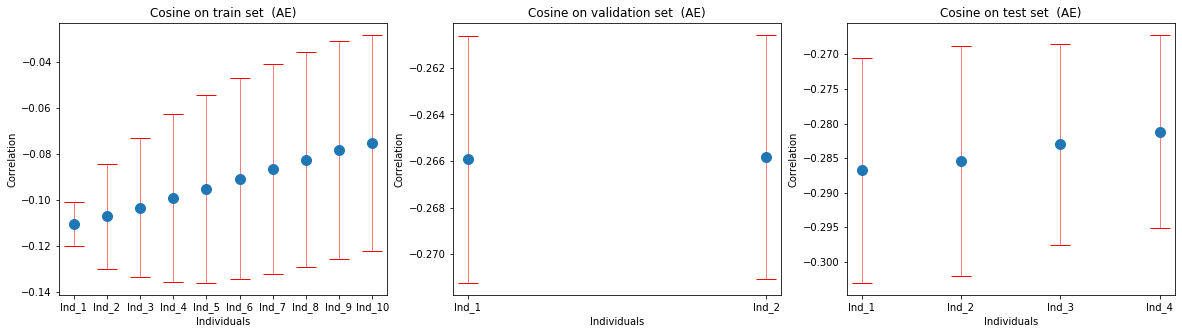

train set mean:  217.21822008405414
train set std:  33.241409173264245
validation set mean:  1998.391369047619
validation set std:  2.57665969646488
test set mean:  1995.119361514137
test set std:  6.124074982564129


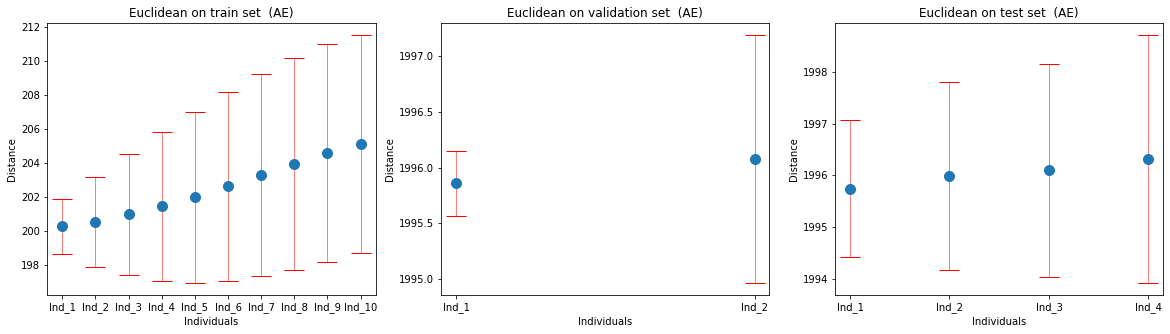

In [31]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Top-K ranking synthesis

In [29]:
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_network, bold_network, decoder_network=(tmp_eeg_network, tmp_bold_network, tmp_decoder_network)

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False)


validation_loss = custom_training.ranked_synthesis_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network, 
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            bold_network=bold_network, 
                                                            epochs=40, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            loss_function=losses.get_reconstruction_log_cosine_loss,
                                                            batch_size=batch_size, 
                                                            top_k=1, 
                                                            eeg_train=eeg_train, 
                                                            bold_train=bold_train, 
                                                            eeg_val=eeg_val, 
                                                            bold_val=bold_val,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y)

model_name="Top-5"


#1 - 
#2 - 
#3 - 
#4 - 
#5 - 
#6 - 
#7 - 
#8 - 
#9 - 
#10 - 

Encoder Loss:  0.11282042
Encoder Loss:  0.11160814
Encoder Loss:  0.11156601
Encoder Loss:  0.111565895
Encoder Loss:  0.1115658
Encoder Loss:  0.11156566
Encoder Loss:  0.11156551
Encoder Loss:  0.111565374
Encoder Loss:  0.11156522
Encoder Loss:  0.11156504
Encoder Loss:  0.111564845
Encoder Loss:  0.111564696
Encoder Loss:  0.1115645
Encoder Loss:  0.11156437
Encoder Loss:  0.11156421
Encoder Loss:  0.11156412
Encoder Loss:  0.11156404
Encoder Loss:  0.11156403
Encoder Loss:  0.11156394
Encoder Loss:  0.111563906
Encoder Loss:  0.1115639
Encoder Loss:  0.11156388
Encoder Loss:  0.11156386
Encoder Loss:  0.11156385
Encoder Loss:  0.11156383
Encoder Loss:  0.1115638
Encoder Loss:  0.11156379
Encoder Loss:  0.11156379
Encoder Loss:  0.11156379
Encoder Loss:  0.11156376
Encoder Loss:  0.11156376
Encoder Loss:  0.11156376
Encoder Loss:  0.11156374
Encoder Loss:  0.11156373
Encoder Loss:  0.11156374
Encoder Loss:  0.111563735
Encoder Loss:  0.11156371
Encoder Loss:  0.11156371
Encoder Lo

train set mean:  -3.691014379262924
train set std:  0.053199456812835014
validation set mean:  -3.7480901976426444
validation set std:  0.0076260561322854525
test set mean:  -3.729722521305084
test set std:  0.02538251726273856


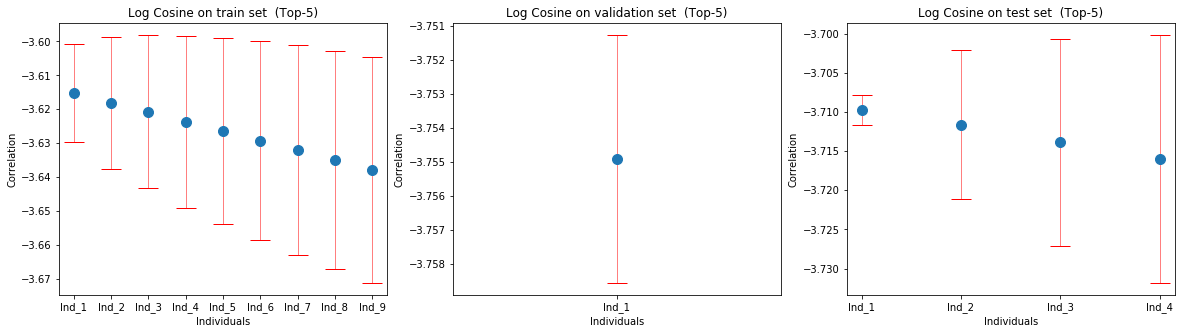

train set mean:  -10.957150852680206
train set std:  0.5932736581227831
validation set mean:  -9.867431104183197
validation set std:  0.11899969277373315
test set mean:  -9.699605426788331
test set std:  0.32679610580100976


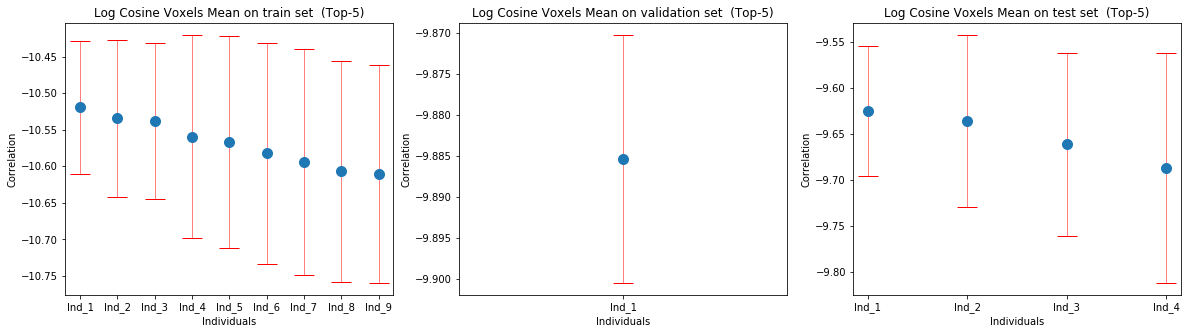

train set mean:  0.9750175930559635
train set std:  0.0013512266293394556
validation set mean:  0.9764366100231806
validation set std:  0.00017970272913722207
test set mean:  0.9759927743673324
test set std:  0.0006096190013035258


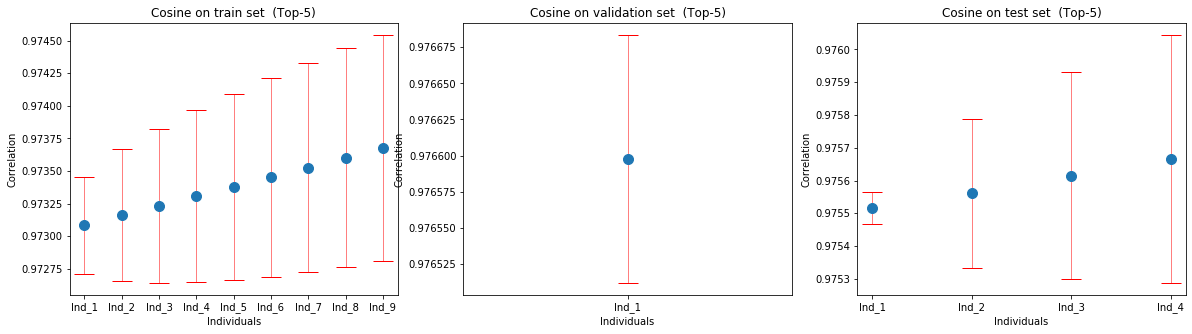

train set mean:  -0.9999794691801072
train set std:  1.1284471001450106e-05
validation set mean:  -0.9999477192759514
validation set std:  8.331491614571347e-06
test set mean:  -0.9999356788396835
test set std:  1.826827357049064e-05


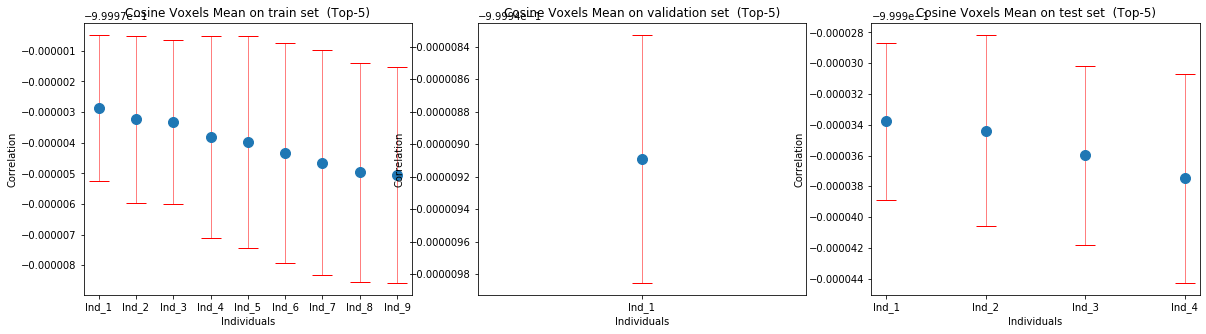

train set mean:  2761.6338826497395
train set std:  30.746588645155054
validation set mean:  3131.445551554362
validation set std:  1.9169887093075588
test set mean:  3128.40123046875
test set std:  7.171997890734322


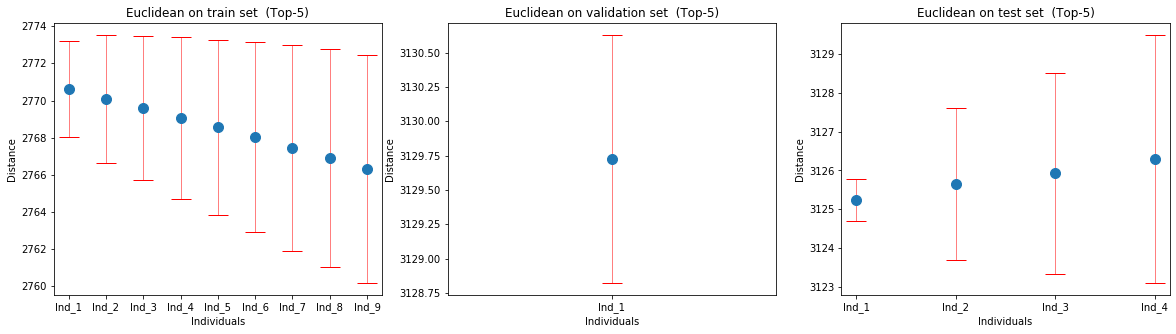

train set mean:  10333.0875
train set std:  115.04318818478986
validation set mean:  11716.79600016276
validation set std:  7.172372852627546
test set mean:  11705.40501953125
test set std:  26.834921071309804


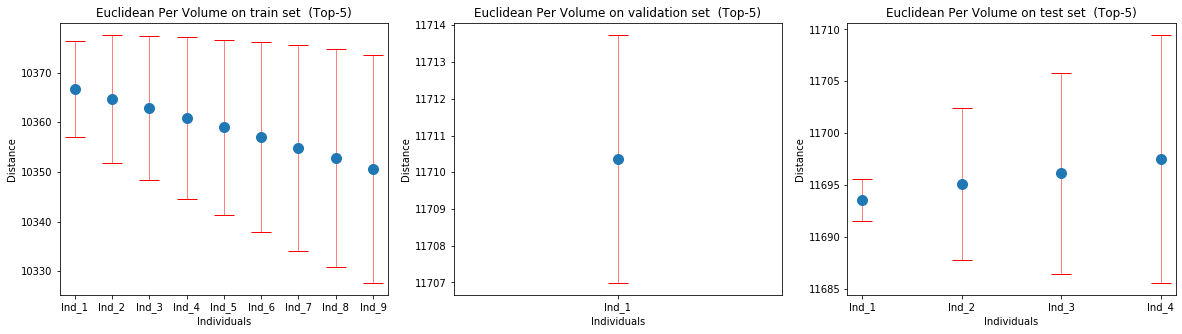

In [13]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)